<a href="https://colab.research.google.com/github/eyalgur1/Machine_Learning_Techniques/blob/main/RegressionComparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Packages and Data Generation**🚫

In [1]:
#@title #####**Import Packages**🚫
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cvx
from IPython.display import Latex
import sklearn
import sklearn.ensemble
import sklearn.tree
import sklearn.datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import xgboost as xgb
import importlib

In [ ]:
#@title #####**Mount Drive and Install Latex**🚫

from google.colab import drive
drive.mount("/content/drive/")

# Install LaTeX and related packages
!sudo apt-get update -qq
!sudo apt-get install -y texlive texlive-latex-extra dvipng texlive-fonts-recommended cm-super

plt.rcParams.update({
    "text.usetex": True,             # Use LaTeX for all text
    "font.family": "serif",          # Use serif fonts
    "font.serif": ["Computer Modern Roman"],  # Use Computer Modern Roman font
    "text.latex.preamble": r"\usepackage{amsmath}",  # Load additional packages
    "font.size": 16,                 # Default font size
    "axes.titlesize": 14,            # Title font size
    "axes.labelsize": 14,            # Axis labels font size
    "xtick.labelsize": 14,           # X-tick labels font size
    "ytick.labelsize": 14,           # Y-tick labels font size
    "legend.fontsize": 14
})

In [3]:
#@title #####**Functions for Generation of Tabular Data**🚫

def createTabularData(features, target, scaler, val_per, test_per):
    # Input:
    # features: a numerical array of column features
    # target: a numerical array of target labels
    # scaler: a string with 'minmax' or 'standard' data scaler
    # Output:
    # dataset: dictionary with 6 items: feature_train/val/test and target_train/val/test


    # Split to train/validation/test sets (before preprocessing)
    X_train_pre, X_remain, y_train_pre, y_remain = train_test_split(features, target.reshape(-1,1), test_size=val_per+test_per, random_state=1)  # split and fix the seed
    X_val_pre, X_test_pre, y_val_pre, y_test_pre = train_test_split(X_remain, y_remain, test_size=test_per/(val_per+test_per), random_state=1)


    # Initialize scalers to normalize the data to have the same scale
    if scaler.lower() in ['minmax']:
        scaler_X = sklearn.preprocessing.MinMaxScaler()  # initializes a scaler that scales any column to [0,1] (column-wise)
        scaler_y = sklearn.preprocessing.MinMaxScaler()  # scaler for y
    elif scaler.lower() in ['standard']:
        scaler_X = sklearn.preprocessing.StandardScaler()  # initializes a scaler by removing the mean and scaling to unit variance (column-wise)
        scaler_y = sklearn.preprocessing.StandardScaler()  # scaler for y
    else:
        raise ValueError("No scaler named '"+scaler.lower()+"'. Set scaler='minmax' or scaler='standard'.")


    # Scale the data according to the training set
    # Tranforms that data according to the limits already set by the training set
    X_train = scaler_X.fit_transform(X_train_pre)
    X_val, X_test = (scaler_X.transform(X_val_pre), scaler_X.transform(X_test_pre))
    y_train = scaler_y.fit_transform(y_train_pre)
    y_val, y_test = (scaler_y.transform(y_val_pre), scaler_y.transform(y_test_pre))


    tabular_dataset = dict(feature_train = X_train, target_train = y_train,
                           feature_val = X_val, target_val = y_val,
                           feature_test = X_test, target_test = y_test,
                           inv_feature_scale = scaler_X.inverse_transform,
                           inv_target_scale = scaler_y.inverse_transform)
    return tabular_dataset


# Auxiliary function for dynamic data import by the user
def dynamic_import(module_name: str, object_name: str):
    # Import the module dynamically
    module = importlib.import_module(module_name)

    # Import the specific object from the module
    imported_object = getattr(module, object_name)

    return imported_object

## **Implementation of Regressors**🚫

In [65]:
#@title #####*Gradient Boosting Trainer*
#@markdown A functional gradient descent on fitted trees, where at iteration we fit a tree using the previous fits as a "descent direction". Here we use XGBoost as an API for sklearn.
def gradBoostRegTrain(dataset, num_epochs, n_estimators, lr, max_depth):

    gradBoost = xgb.XGBRegressor(objective='reg:squarederror', n_estimators = n_estimators,
                                 learning_rate = lr, max_depth = max_depth, eval_metric = ['rmse'])

    X_train = dataset['feature_train'];  y_train = dataset['target_train']
    X_test = dataset['feature_test'];  y_test = dataset['target_test']
    eval_set = [(X_train, y_train), (dataset['feature_val'], dataset['target_val'])]
    inv_y_scale = dataset['inv_target_scale']
    verbosity = gradBoost.n_estimators
    results = {'mse_train':np.array([]), 'mse_val':np.array([]), 'mse_test':0, 'num_epochs':num_epochs}

    print("\033[4mGradient Boosting Regressor Training\033[0m", '\n')
    print("Notice: validation_0=Training Set, validation_1=Validation Set", '\n')


    # Training loop
    for epoch in range(num_epochs):
        print('Epoch ', str(epoch+1), '/', str(num_epochs))
        if epoch == 0:  # first epoch
            gradBoost.fit(X_train, y_train, eval_set=eval_set, verbose=verbosity)
            # eval_set: the data on which to track metric evaluation; can also be set as eval_set=[(X_train, y_train)]; eval_set is not used for training
            # verbose: integer specifying the intervals of trees to specify metrics for (out of n_estimators in total)
        else:
            gradBoost.fit(X_train, y_train, eval_set=eval_set, verbose=verbosity, xgb_model=gradBoost.get_booster())
            # after the first epoch, we use the previous fitted model as starting point with the command xgb_model=xgb_model.get_booster()


        # Save MSE for later plotting
        results_epoch = gradBoost.evals_result()
        results['mse_train'] = np.append(results['mse_train'], np.array(results_epoch['validation_0']['rmse'])**2)
        results['mse_val'] = np.append(results['mse_val'], np.array(results_epoch['validation_1']['rmse'])**2)

    y_pred = gradBoost.predict(X_test).reshape(-1,1)
    results['mse_test'] = mean_squared_error(y_test, y_pred)

    # Evaluate the model's performance (transform back to terms of original prices)
    mse_test_price = mean_squared_error(inv_y_scale(y_test), inv_y_scale(y_pred))
    print('\n', 'Test MSE: ', results['mse_test'])
    print('Test MSE in terms of original prices: ', mse_test_price, '\n')

    return gradBoost, results


def gradBoostPlot(gradBoost, results):
    # Training and validation sets
    plt.figure(figsize=(5, 3))
    plt.semilogy(results['mse_train'])  # the training set
    plt.semilogy(results['mse_val'])  # the validation set
    plt.title('Gradient Boosting: MSE')
    plt.xlabel(r'Iterations (\#trees $\times$ \#epochs)')
    xlim = gradBoost.n_estimators*results['num_epochs']
    plt.xlim([0, xlim])

    # Test set prediction
    plt.semilogy(np.ones((xlim, 1))*results['mse_test'])
    plt.legend(['Training set', 'Validation set', 'Test set output'])
    plt.show()
    print('\n\n\n')

In [66]:
#@title #####*Bagged Trees Trainer*
#@markdown Fits base regressors each on random subsets of the original dataset, and then aggregates their individual predictions (by averaging) to form a final prediction. Reduces the variance of an estimator by introducing randomization. This implementaion considers all dataset (hence, just shuffles the data for each tree).
def baggedTreesRegTrain(dataset, max_depth, n_estimators):

    X_train = dataset['feature_train'];  y_train = dataset['target_train'].ravel()
    X_val = dataset['feature_val']; y_val = dataset['target_val']
    X_test = dataset['feature_test'];  y_test = dataset['target_test']
    inv_y_scale = dataset['inv_target_scale']
    results = {'mse_train':np.array([]), 'mse_val':np.array([]), 'mse_test':np.array([]), 'max_depth':max_depth, 'n_estimators':n_estimators}

    print("\033[4mBagged Trees Regressor Training\033[0m", '\n')


    # Training loop
    for depth in range(max_depth):
        print('Depth', str(depth+1), '/', str(max_depth))
        baggedTrees = sklearn.ensemble.BaggingRegressor(estimator=sklearn.tree.DecisionTreeRegressor(max_depth=depth+1), verbose = 1)
        baggedTrees.fit(X_train, y_train)

        y_depth_train = baggedTrees.predict(X_train).reshape(-1,1); mse_train = mean_squared_error(y_train, y_depth_train)
        y_depth_val = baggedTrees.predict(X_val).reshape(-1,1); mse_val = mean_squared_error(y_val, y_depth_val)
        y_depth_test = baggedTrees.predict(X_test).reshape(-1,1); mse_test = mean_squared_error(y_test, y_depth_test)
        print('Training MSE: ', mse_train, '| Validation MSE: ', mse_val, '| Test MSE: ', mse_test, '\n')

        # Save MSE for later plotting
        results['mse_train'] = np.append(results['mse_train'], mse_train)
        results['mse_val'] = np.append(results['mse_val'], mse_val)
        results['mse_test'] = np.append(results['mse_test'], mse_test)


    # Evaluate the model's performance (transform back to terms of original prices)
    mse_test_price = mean_squared_error(inv_y_scale(y_test).reshape(-1,1), inv_y_scale(y_depth_test).reshape(-1,1))  # convert to previous prices for the maximal depth
    print('\n', 'Test MSE for maximal depth: ', results['mse_test'][-1])
    print('Test MSE in terms of original prices for maximal depth: ', mse_test_price, '\n')


    "This code below updates the Bagged Trees with an epoch loop (instead of a depth loop), and increases the number of estimators at each epoch with awarm start of the prvious fit model"
    "The corresponding plotting function is not updated according to this variant"
    # X_train = dataset['feature_train'];  y_train = dataset['target_train'].ravel()
    # X_val = dataset['feature_val']; y_val = dataset['target_val']
    # X_test = dataset['feature_test'];  y_test = dataset['target_test']
    # inv_y_scale = dataset['inv_target_scale']
    # trees_per_epoch = n_estimators // num_epochs
    # results = {'mse_train':np.array([]), 'mse_val':np.array([])}

    # baggedTrees = sklearn.ensemble.BaggingRegressor(estimator=sklearn.tree.DecisionTreeRegressor(max_depth=max_depth),
    #                                      n_estimators = trees_per_epoch, verbose = 1,
    #                                      warm_start = True)

    # print("\033[4mBagged Trees Regressor Training\033[0m", '\n')


    # # Training loop
    # for epoch in range(num_epochs):
    #     print('Epoch', str(epoch+1), '/', str(num_epochs), '|| #estimators:', baggedTrees.n_estimators)
    #     baggedTrees.fit(X_train, y_train)

    #     y_epoch_train = baggedTrees.predict(X_train).reshape(-1,1); mse_train = mean_squared_error(y_train, y_epoch_train)
    #     y_epoch_val = baggedTrees.predict(X_val).reshape(-1,1); mse_val = mean_squared_error(y_val, y_epoch_val)
    #     print('Training MSE: ', mse_train, '| Validation MSE: ', mse_val, '\n')

    #     # Save MSE for later plotting
    #     results['mse_train'] = np.append(results['mse_train'], mse_train)
    #     results['mse_val'] = np.append(results['mse_val'], mse_val)

    #     baggedTrees.n_estimators += trees_per_epoch


    # y_pred = baggedTrees.predict(X_test).reshape(-1,1)
    # results['mse_test'] = mean_squared_error(y_test, y_pred)

    # # Evaluate the model's performance (transform back to terms of original prices)
    # mse_test_price = mean_squared_error(inv_y_scale(y_test), inv_y_scale(y_pred))
    # print('\n', 'Test MSE: ', results['mse_test'])
    # print('Test MSE in terms of original prices: ', mse_test_price, '\n')

    return baggedTrees, results


def baggedTreesPlot(baggedTrees, results):
    # Training and validation sets
    plt.figure(figsize=(5, 3))
    plt.plot(results['mse_train'])  # the training set
    plt.plot(results['mse_val'])  # the validation set
    plt.plot(results['mse_test'])  # the test set
    plt.title("Bagged Trees (with "+str(results['n_estimators'])+" estimators): MSE")
    plt.xlabel(r'Depth')
    xlim = results['max_depth']
    plt.xlim([0, xlim-1])
    xticks = [tick for tick in range(0,xlim)]
    xtick_labels = [f'{tick+1}' for tick in range(0,xlim)]
    plt.xticks(xticks, xtick_labels)


    plt.legend(['Training set', 'Validation set', 'Test set'])
    plt.show()
    print('\n\n\n')

In [67]:
#@title #####*Random Forest Trainer*
#@markdown Fits a number of decision tree regressors on (possibly various random sub-samples of) the dataset, by randomly selecting a sub-set of the features at each split, and averages to improve the predictive accuracy and control over-fitting. Equivalent to Bagged Trees if selecting all features at each split. This implementaion considers all dataset (hence, just shuffles the data for each tree).
def randomForestRegTrain(dataset, max_depth, n_estimators):

    X_train = dataset['feature_train'];  y_train = dataset['target_train'].ravel()
    X_val = dataset['feature_val']; y_val = dataset['target_val']
    X_test = dataset['feature_test'];  y_test = dataset['target_test']
    inv_y_scale = dataset['inv_target_scale']
    results = {'mse_train':np.array([]), 'mse_val':np.array([]), 'mse_test':np.array([]), 'max_depth':max_depth, 'n_estimators':n_estimators}

    print("\033[4mRandom Forest Regressor Training\033[0m", '\n')


    # Training loop
    for depth in range(max_depth):
        print('Depth', str(depth+1), '/', str(max_depth))
        randomForest = sklearn.ensemble.RandomForestRegressor(max_features='sqrt', n_estimators=n_estimators, max_depth=depth+1, verbose = 1)
        randomForest.fit(X_train, y_train)

        y_depth_train = randomForest.predict(X_train).reshape(-1,1); mse_train = mean_squared_error(y_train, y_depth_train)
        y_depth_val = randomForest.predict(X_val).reshape(-1,1); mse_val = mean_squared_error(y_val, y_depth_val)
        y_depth_test = randomForest.predict(X_test).reshape(-1,1); mse_test = mean_squared_error(y_test, y_depth_test)
        print('Training MSE: ', mse_train, '| Validation MSE: ', mse_val, '| Test MSE: ', mse_test, '\n')

        # Save MSE for later plotting
        results['mse_train'] = np.append(results['mse_train'], mse_train)
        results['mse_val'] = np.append(results['mse_val'], mse_val)
        results['mse_test'] = np.append(results['mse_test'], mse_test)


    # Evaluate the model's performance (transform back to terms of original prices)
    mse_test_price = mean_squared_error(inv_y_scale(y_test).reshape(-1,1), inv_y_scale(y_depth_test).reshape(-1,1))  # convert to previous prices for the maximal depth
    print('\n', 'Test MSE for maximal depth: ', results['mse_test'][-1])
    print('Test MSE in terms of original prices for maximal depth: ', mse_test_price, '\n')


    "Random Forest can be trained with an epoch loop (instead of a depth loop -- see note at the bottom of the Bagged Tree Regressor function), and increases the number of estimators at each epoch with a warm start of the prvious fit model"
    "The corresponding plotting function is not updated according to this variant"

    return baggedTrees, results


def randomForestPlot(baggedTrees, results):
    # Training and validation sets
    plt.figure(figsize=(5, 3))
    plt.plot(results['mse_train'])  # the training set
    plt.plot(results['mse_val'])  # the validation set
    plt.plot(results['mse_test'])  # the test set
    plt.title("Random Forest (with "+str(results['n_estimators'])+" estimators): MSE")
    plt.xlabel(r'Depth')
    xlim = results['max_depth']
    plt.xlim([0, xlim-1])
    xticks = [tick for tick in range(0,xlim)]
    xtick_labels = [f'{tick+1}' for tick in range(0,xlim)]
    plt.xticks(xticks, xtick_labels)


    plt.legend(['Training set', 'Validation set', 'Test set'])
    plt.show()
    print('\n\n\n')

In [64]:
#@title #####*Decision Tree Trainer*
#@markdown Predicts the value of a target variable by learning simple (if-then-else) decision rules. A tree can be seen as a piecewise constant approximation.
def decisionTreeRegTrain(dataset, max_depth):

    X_train = dataset['feature_train'];  y_train = dataset['target_train'].ravel()
    X_val = dataset['feature_val']; y_val = dataset['target_val']
    X_test = dataset['feature_test'];  y_test = dataset['target_test']
    inv_y_scale = dataset['inv_target_scale']
    results = {'mse_train':np.array([]), 'mse_val':np.array([]), 'mse_test':np.array([]), 'max_depth':max_depth}

    print("\033[4mDecision Tree Regressor Training\033[0m", '\n')


    # Training loop
    for depth in range(max_depth):
        print('Depth', str(depth+1), '/', str(max_depth))
        decisionTree = sklearn.tree.DecisionTreeRegressor(max_depth = depth+1)
        decisionTree.fit(X_train, y_train)

        y_depth_train = decisionTree.predict(X_train).reshape(-1,1); mse_train = mean_squared_error(y_train, y_depth_train)
        y_depth_val = decisionTree.predict(X_val).reshape(-1,1); mse_val = mean_squared_error(y_val, y_depth_val)
        y_depth_test = decisionTree.predict(X_test).reshape(-1,1); mse_test = mean_squared_error(y_test, y_depth_test)
        print('Training MSE: ', mse_train, '| Validation MSE: ', mse_val, '| Test MSE: ', mse_test, '\n')

        # Save MSE for later plotting
        results['mse_train'] = np.append(results['mse_train'], mse_train)
        results['mse_val'] = np.append(results['mse_val'], mse_val)
        results['mse_test'] = np.append(results['mse_test'], mse_test)


    # Evaluate the model's performance (transform back to terms of original prices)
    mse_test_price = mean_squared_error(inv_y_scale(y_test).reshape(-1,1), inv_y_scale(y_depth_test).reshape(-1,1))  # convert to previous prices for the maximal depth
    print('\n', 'Test MSE for maximal depth: ', results['mse_test'][-1])
    print('Test MSE in terms of original prices for maximal depth: ', mse_test_price, '\n')

    return decisionTree, results


def decisionTreePlot(decisionTree, results):
    # Training and validation sets
    plt.figure(figsize=(5, 3))
    plt.plot(results['mse_train'])  # the training set
    plt.plot(results['mse_val'])  # the validation set
    plt.plot(results['mse_test'])  # the test set
    plt.title('Decision Tree: MSE')
    plt.xlabel(r'Depth')
    xlim = results['max_depth']
    plt.xlim([0, xlim-1])
    xticks = [tick for tick in range(0,xlim)]
    xtick_labels = [f'{tick+1}' for tick in range(0,xlim)]
    plt.xticks(xticks, xtick_labels)


    plt.legend(['Training set', 'Validation set', 'Test set'])
    plt.show()
    print('\n\n\n')

In [68]:
#@title #####*$\ell_2$ Linear Regression*
#@markdown A simple $\ell_2$-regression with exact solution.

#@markdown *Note:* Using a polynomial linear regression for multi-feature setting is expensive, as the Vandermonde matrix is too large for accurate inversion even when the poly degree is small. For a polynomial linear regression, one can use gradient descent (not implemented here).

def linearRegTrain(dataset, intercept=False):

    X_train = dataset['feature_train'];  y_train = dataset['target_train'].ravel()
    # notice that there is no need here for the validation set, as there is no loop here (so there is no need to deduce from a validation set regarding hyperparameters)
    X_test = dataset['feature_test'];  y_test = dataset['target_test']
    inv_y_scale = dataset['inv_target_scale']
    results = {'mse_train':np.array([]), 'mse_val':np.array([]), 'mse_test':np.array([])}

    def leastSqaures(A_train, b, intercept, A_test):
        if ~intercept:  # if intercept is not required
            A_train = np.append(np.ones((A_train.shape[0], 1)), A_train, 1)  # append column of ones for free coefficient (Vendermonde)
            A_test = np.append(np.ones((A_test.shape[0], 1)), A_test, 1)
        AT_train = np.transpose(A_train)
        return 0.5*np.linalg.inv(AT_train@A_train)@AT_train@b, A_train, A_test  # return least squares solution

    print("\033[4m$\ell_2$ Linear Regression Training\033[0m", '\n')

    linearReg, A_train, A_test = leastSqaures(X_train, y_train, intercept, X_test)

    y_pred_train = A_train@linearReg; y_pred_train = y_pred_train.reshape(-1,1)
    mse_train = mean_squared_error(y_pred_train, y_train); results['mse_train'] = mse_train

    y_pred = A_test@linearReg; y_pred = y_pred.reshape(-1,1)
    mse_test = mean_squared_error(y_pred, y_test); results['mse_test'] = mse_test
    mse_test_price = mean_squared_error(inv_y_scale(y_test), inv_y_scale(y_pred))
    print('Training MSE: ', mse_train, '| Test MSE: ', mse_test, '\n', 'Test MSE in terms of original prices: ', mse_test_price, '\n\n')

    return linearReg, results

In [63]:
#@title #####*$k$-NN Regressor*
#@markdown $k$-nearest neighbors regression, that finds the $\ell_2$-closest neighbors to the traget point, and assigns the average value of the neighbors to the target point.
def kNNRegTrain(dataset, n_neighbors):

    X_train = dataset['feature_train'];  y_train = dataset['target_train'].ravel()
    X_val = dataset['feature_val']; y_val = dataset['target_val']
    X_test = dataset['feature_test'];  y_test = dataset['target_test']
    inv_y_scale = dataset['inv_target_scale']
    results = {'mse_train':np.array([]), 'mse_val':np.array([]), 'mse_test':np.array([]), 'max_neighbors':n_neighbors}

    print("\033[4mk-NN Regressor Training\033[0m", '\n')


    # Training loop
    for k in range(n_neighbors):
        print('#neighbors: ', str(k+1), '/', str(n_neighbors))
        kNN = sklearn.neighbors.KNeighborsRegressor(n_neighbors = k+1)
        kNN.fit(X_train, y_train)

        y_neigh_train = kNN.predict(X_train).reshape(-1,1); mse_train = mean_squared_error(y_train, y_neigh_train)
        y_neigh_val = kNN.predict(X_val).reshape(-1,1); mse_val = mean_squared_error(y_val, y_neigh_val)
        y_neigh_test = kNN.predict(X_test).reshape(-1,1); mse_test = mean_squared_error(y_test, y_neigh_test)
        print('Training MSE: ', mse_train, '| Validation MSE: ', mse_val, '| Test MSE: ', mse_test, '\n')

        # Save MSE for later plotting
        results['mse_train'] = np.append(results['mse_train'], mse_train)
        results['mse_val'] = np.append(results['mse_val'], mse_val)
        results['mse_test'] = np.append(results['mse_test'], mse_test)


    # Evaluate the model's performance (transform back to terms of original prices)
    mse_test_price = mean_squared_error(inv_y_scale(y_test).reshape(-1,1), inv_y_scale(y_neigh_test).reshape(-1,1))  # convert to previous prices for the maximal k
    print('\n', 'Test MSE for maximal neighbors: ', results['mse_test'][-1])
    print('Test MSE in terms of original prices for maximal neighbors: ', mse_test_price, '\n')

    return kNN, results


def kNNPlot(kNN, results):
    # Training and validation sets
    plt.figure(figsize=(5, 3))
    plt.plot(results['mse_train'])  # the training set
    plt.plot(results['mse_val'])  # the validation set
    plt.plot(results['mse_test'])  # the test set
    plt.title('$k$-NN: MSE')
    plt.xlabel(r'\# neighbors')
    xlim = results['max_neighbors']
    plt.xlim([0, xlim-1])
    xticks = [tick for tick in range(0,xlim)]
    xtick_labels = [f'{tick+1}' for tick in range(0,xlim)]
    plt.xticks(xticks, xtick_labels)


    plt.legend(['Training set', 'Validation set', 'Test set'])
    plt.show()
    print('\n\n\n')

In [57]:
#@title #####*2-layered Neaural Network Regressor*
#@markdown A simple regression PyTorch net with one hidden layer. The activation function is ReLU, optimizer is Adam, loss is MSELoss, and lr is given by the user.
def neuralNetReg(dataset, hidden_dim, lr, num_epochs):

    class SimpleRegressionModel(nn.Module):
        def __init__(self, input_dim, hidden_dim, output_dim):
            super(SimpleRegressionModel, self).__init__()
            self.hidden = nn.Linear(input_dim, hidden_dim)
            self.relu = nn.ReLU()
            self.output = nn.Linear(hidden_dim, output_dim)

        def forward(self, x):
            x = self.hidden(x)
            x = self.relu(x)
            x = self.output(x)
            return x


    X_train = torch.tensor(dataset['feature_train'].astype(np.float32));  y_train = torch.tensor(dataset['target_train'].astype(np.float32))
    X_val = torch.tensor(dataset['feature_val'].astype(np.float32)); y_val = torch.tensor(dataset['target_val'].astype(np.float32))
    X_test = torch.tensor(dataset['feature_test'].astype(np.float32));  y_test = torch.tensor(dataset['target_test'].astype(np.float32))
    inv_y_scale = dataset['inv_target_scale']
    results = {'mse_train':np.array([]), 'mse_val':np.array([]), 'mse_test':np.array([]), 'num_epochs':num_epochs, 'hidden_dim':hidden_dim}


    model = SimpleRegressionModel(input_dim=X_train.shape[1], hidden_dim=hidden_dim, output_dim=y_train.shape[1])
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)


    print("\033[4m2-layer Neural Network Training\033[0m", '\n')
    for epoch in range(num_epochs):

        permutation = np.random.permutation(len(X_train))
        X_train = X_train[permutation]
        y_train = y_train[permutation]

        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        results['mse_train'] = np.append(results['mse_train'], loss.item())

        model.eval()
        with torch.no_grad():
            y_epoch_val = model(X_val)
            val_loss = criterion(y_epoch_val, y_val)
            results['mse_val'] = np.append(results['mse_val'], val_loss.item())

        print(f'Epoch [{epoch+1}/{num_epochs}], Training MSE: {loss.item():.4f}| Validation MSE: {val_loss.item():.4f}')


    # Evaluate the model's performance (transform back to terms of original prices)
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
        test_loss = criterion(y_pred, y_test)
        results['mse_test'] = test_loss.item()
    mse_test_price = mean_squared_error(inv_y_scale(np.array(y_test)).reshape(-1,1), inv_y_scale(np.array(y_pred)).reshape(-1,1))  # convert to previous prices for the maximal k
    print('\n', 'Test MSE: ', test_loss.item())
    print('Test MSE in terms of original prices: ', mse_test_price, '\n')

    return results


def neuralNetPlot(results):
    # Training and validation sets
    plt.figure(figsize=(5, 3))
    plt.semilogy(results['mse_train'])  # the training set
    plt.semilogy(results['mse_val'])  # the validation set
    plt.title("$2$-layared Neural Network with hidden size="+str(results['hidden_dim'])+": MSE")
    plt.xlabel(r'Epochs')
    xlim = results['num_epochs']
    plt.xlim([0, xlim-1])
    xticks = [tick for tick in range(0,xlim)]
    xtick_labels = [f'{tick+1}' for tick in range(0,xlim)]
    plt.xticks(xticks, xtick_labels)

    plt.semilogy(results['mse_test']*np.ones((xlim,1)))
    plt.legend(['Training set', 'Validation set', 'Test output'])
    plt.show()
    print('\n\n\n')

## **Generate Tabular Dataset**👇

In [36]:
# @title ##### **Define a Tabular Dataset**
# @markdown Tick for choosing a dataset from `sklearn.datasets` and enter its name. Else, the local `kaggle` dataset `weatherww2` is loaded.
sklearn_dataset = False # @param {type:"boolean"}
if sklearn_dataset:
    module_name = "sklearn.datasets"
    object_name = "fetch_california_housing" # @param {type:"string"}
    dataset_object = dynamic_import(module_name, object_name)  # each row in this dataset is the average of several houses in one block
    raw_dataset = pd.DataFrame(data = dataset_object())  # convert to a pandas DataFrame (for better treating of missing values)
else:
    path = '/content/drive/MyDrive/Colab_Notebooks/Machine_and_Deep_Learning/ML/melbourne_housing.csv'
    dataset_object = pd.read_csv(path)
    raw_dataset = dataset_object.drop(['Suburb', 'Address', 'Type','Method','SellerG','Date','CouncilArea','Regionname'], axis=1)  # delete these columns


# Remove all rows with missing values (hence, it assumes that the data is highly non-sparse)
# Removing missing values using `pandas` (treats all types of mssing values at once, unlike numpy)
raw_dataset = raw_dataset.dropna(how='any')  # drop any row that has at least one NaN, either in the features


# @markdown Set percentage of the validation and test sets out of the complete data (the remainder is the training set).
val_per = 0.1 # @param {type:"number"}
test_per = 0.1 # @param {type:"number"}


# @markdown Set data scaler type (`minmax` or `standard`)
scaler = 'minmax' # @param {type:"string"}


# Create a tabular numeric dataset (clean and scale)
if sklearn_dataset:
    dataset = createTabularData(features=np.array(raw_dataset['data']), target=np.array(raw_dataset['target']),
                      scaler=scaler, val_per=val_per, test_per=test_per)
else: dataset = createTabularData(features=np.array(raw_dataset.drop('Price', axis=1)), target=np.array(raw_dataset['Price']).reshape(-1,1),
                      scaler=scaler, val_per=val_per, test_per=test_per)

## **Set Hyperparameters**👇

In [69]:
#@title #####**Define Parameters**

kNN = True # @param {type:"boolean"}
n_neighbors = 20 # @param {type:"integer"}
#@markdown ---

decision_tree = True # @param {type:"boolean"}
max_depth_DT = 10 # @param {type:"integer"}
#@markdown ---

bagged_trees = True # @param {type:"boolean"}
n_estimators_BT = 100 # @param {type:"integer"}
max_depth_BT = 10 # @param {type:"integer"}
#@markdown ---

random_forest = True # @param {type:"boolean"}
n_estimators_RF = 100 # @param {type:"integer"}
max_depth_RF = 10 # @param {type:"integer"}
#@markdown ---

gradient_boosting = True # @param {type:"boolean"}
n_estimators_GB = 100# @param {type:"integer"}
max_depth_GB = 5# @param {type:"integer"}
lr_GB = 0.1# @param {type:"number"}
num_epochs_GB = 5# @param {type:"integer"}
#@markdown ---

linear_regression = True # @param {type:"boolean"}
intercept = False # @param {type:"boolean"}
#@markdown ---

neural_network = True # @param {type:"boolean"}
hidden_dim_NN = 10# @param {type:"integer"}
lr_NN = 0.01# @param {type:"number"}
num_epochs_NN = 20# @param {type:"integer"}

## **Train the Regressors**👇

Decision Tree Regressor Training 

Depth 1 / 10
Training MSE:  0.004508611507453019 | Validation MSE:  0.004064262099140516 | Test MSE:  0.005304381367863308 

Depth 2 / 10
Training MSE:  0.0034628768700458268 | Validation MSE:  0.0031255359804873324 | Test MSE:  0.0039209252651447885 

Depth 3 / 10
Training MSE:  0.0026869973226621674 | Validation MSE:  0.0024365433477557433 | Test MSE:  0.00321950132986827 

Depth 4 / 10
Training MSE:  0.002222830393976979 | Validation MSE:  0.002046015039874738 | Test MSE:  0.003032546460607771 

Depth 5 / 10
Training MSE:  0.0018497430310887894 | Validation MSE:  0.0019616203389020534 | Test MSE:  0.0026297523218546054 

Depth 6 / 10
Training MSE:  0.0015230462147643319 | Validation MSE:  0.0017621929109473548 | Test MSE:  0.0022927071166778876 

Depth 7 / 10
Training MSE:  0.0012727539688750541 | Validation MSE:  0.0017616198124230605 | Test MSE:  0.0021958203165754115 

Depth 8 / 10
Training MSE:  0.0010615696911637216 | Validation MSE:  0.001692

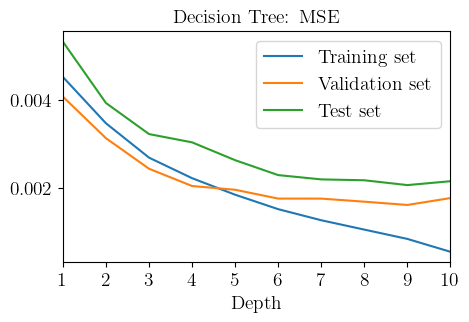





Bagged Trees Regressor Training 

Depth 1 / 10
Training MSE:  0.004413065585880948 | Validation MSE:  0.003930264006828568 | Test MSE:  0.005232675224781193 

Depth 2 / 10
Training MSE:  0.0033472946597135557 | Validation MSE:  0.002995065782898549 | Test MSE:  0.0037991953942777706 

Depth 3 / 10
Training MSE:  0.0025454728836986676 | Validation MSE:  0.002246488476106886 | Test MSE:  0.003067125298228489 

Depth 4 / 10
Training MSE:  0.0020240881833230996 | Validation MSE:  0.0018055075509532173 | Test MSE:  0.0027469448843117144 

Depth 5 / 10
Training MSE:  0.0015910837243772245 | Validation MSE:  0.0014895564026845757 | Test MSE:  0.0022452433069258715 

Depth 6 / 10
Training MSE:  0.0012895860941535091 | Validation MSE:  0.0012094265022720761 | Test MSE:  0.002004029154386184 

Depth 7 / 10
Training MSE:  0.0010731972453283851 | Validation MSE:  0.001187297409907152 | Test MSE:  0.0017454040320814095 

Depth 8 / 10
Training MSE:  0.0008680412355380506 | Validation MSE:  0.001

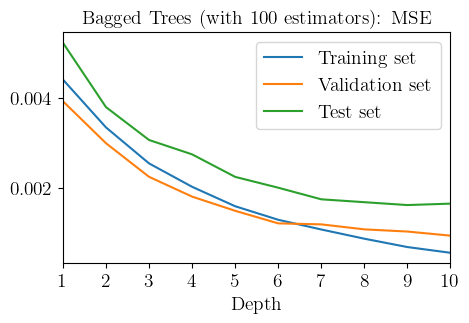





Random Forest Regressor Training 

Depth 1 / 10


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Training MSE:  0.004410384463712995 | Validation MSE:  0.0036707210495499415 | Test MSE:  0.005223652844127851 

Depth 2 / 10


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Training MSE:  0.00331392126629221 | Validation MSE:  0.0027646478082539805 | Test MSE:  0.003981992523289763 

Depth 3 / 10


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Training MSE:  0.0025032452383465112 | Validation MSE:  0.00209300771844528 | Test MSE:  0.003045346123171452 

Depth 4 / 10


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Training MSE:  0.0019708374204039257 | Validation MSE:  0.0016468564964692435 | Test MSE:  0.0024821285397851884 

Depth 5 / 10


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Training MSE:  0.0016286198366681757 | Validation MSE:  0.001367145125257309 | Test MSE:  0.002154580605440281 

Depth 6 / 10


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Training MSE:  0.0013360106773603444 | Validation MSE:  0.001158296327170237 | Test MSE:  0.0018475976560520854 

Depth 7 / 10


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Training MSE:  0.0011293504731295142 | Validation MSE:  0.0010061136268889753 | Test MSE:  0.0017076252549174753 

Depth 8 / 10


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Training MSE:  0.0008999167584692191 | Validation MSE:  0.0008812892093044681 | Test MSE:  0.0015336090429280387 

Depth 9 / 10


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Training MSE:  0.0007297725178503564 | Validation MSE:  0.0008343103235823848 | Test MSE:  0.0014247888456597401 

Depth 10 / 10


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Training MSE:  0.0005808898453152841 | Validation MSE:  0.0007931355375496655 | Test MSE:  0.0013736113969624701 


 Test MSE for maximal depth:  0.0013736113969624701
Test MSE in terms of original prices for maximal depth:  108047120025.10583 



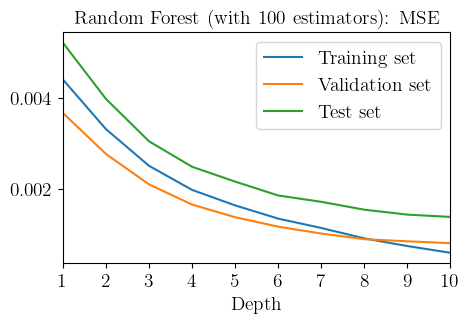





Gradient Boosting Regressor Training 

Notice: validation_0=Training Set, validation_1=Validation Set 

Epoch  1 / 5
[0]	validation_0-rmse:0.07148	validation_1-rmse:0.06514
[99]	validation_0-rmse:0.02335	validation_1-rmse:0.02766
Epoch  2 / 5
[0]	validation_0-rmse:0.02333	validation_1-rmse:0.02765
[99]	validation_0-rmse:0.01863	validation_1-rmse:0.02827
Epoch  3 / 5
[0]	validation_0-rmse:0.01855	validation_1-rmse:0.02848
[99]	validation_0-rmse:0.01585	validation_1-rmse:0.02897
Epoch  4 / 5
[0]	validation_0-rmse:0.01584	validation_1-rmse:0.02897
[99]	validation_0-rmse:0.01380	validation_1-rmse:0.02910
Epoch  5 / 5
[0]	validation_0-rmse:0.01377	validation_1-rmse:0.02910
[99]	validation_0-rmse:0.01236	validation_1-rmse:0.02920

 Test MSE:  0.0012531606493628048
Test MSE in terms of original prices:  98572566066.86296 



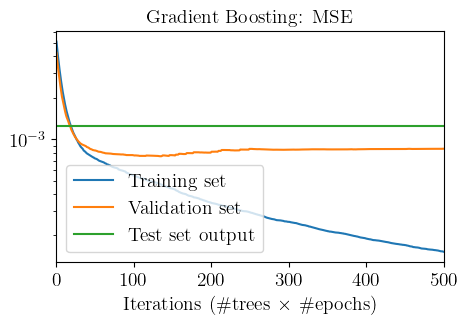





$\ell_2$ Linear Regression Training 

Training MSE:  0.006183265062778126 | Test MSE:  0.007437098324723675 
 Test MSE in terms of original prices:  584995914497.2699 


k-NN Regressor Training 

#neighbors:  1 / 20
Training MSE:  5.214704406218908e-07 | Validation MSE:  0.0021135453414493294 | Test MSE:  0.004060837793857863 

#neighbors:  2 / 20
Training MSE:  0.0006375404903540521 | Validation MSE:  0.0016773008367544184 | Test MSE:  0.002861446004061717 

#neighbors:  3 / 20
Training MSE:  0.0009049409495567025 | Validation MSE:  0.0015179826611984673 | Test MSE:  0.0026280890869373663 

#neighbors:  4 / 20
Training MSE:  0.0010647195704486488 | Validation MSE:  0.0015358330940455724 | Test MSE:  0.0025261202272785542 

#neighbors:  5 / 20
Training MSE:  0.001192989947305015 | Validation MSE:  0.0015224863892740377 | Test MSE:  0.0023716827143218703 

#neighbors:  6 / 20
Training MSE:  0.001263319682564197 | Validation MSE:  0.0014730329927045629 | Test MSE:  0.0023876368258622

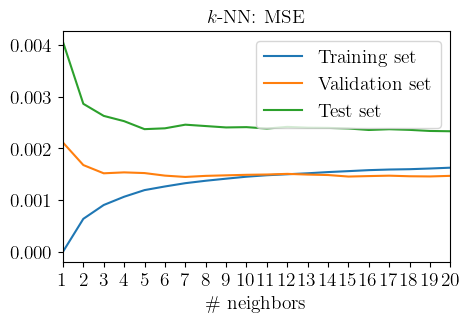





2-layer Neural Network Training 

Epoch [1/20], Training MSE: 0.1071| Validation MSE: 0.0796
Epoch [2/20], Training MSE: 0.0771| Validation MSE: 0.0524
Epoch [3/20], Training MSE: 0.0507| Validation MSE: 0.0308
Epoch [4/20], Training MSE: 0.0299| Validation MSE: 0.0161
Epoch [5/20], Training MSE: 0.0159| Validation MSE: 0.0085
Epoch [6/20], Training MSE: 0.0093| Validation MSE: 0.0084
Epoch [7/20], Training MSE: 0.0101| Validation MSE: 0.0134
Epoch [8/20], Training MSE: 0.0158| Validation MSE: 0.0171
Epoch [9/20], Training MSE: 0.0199| Validation MSE: 0.0180
Epoch [10/20], Training MSE: 0.0209| Validation MSE: 0.0169
Epoch [11/20], Training MSE: 0.0198| Validation MSE: 0.0149
Epoch [12/20], Training MSE: 0.0175| Validation MSE: 0.0125
Epoch [13/20], Training MSE: 0.0149| Validation MSE: 0.0103
Epoch [14/20], Training MSE: 0.0124| Validation MSE: 0.0086
Epoch [15/20], Training MSE: 0.0105| Validation MSE: 0.0075
Epoch [16/20], Training MSE: 0.0091| Validation MSE: 0.0069
Epoch [17/2

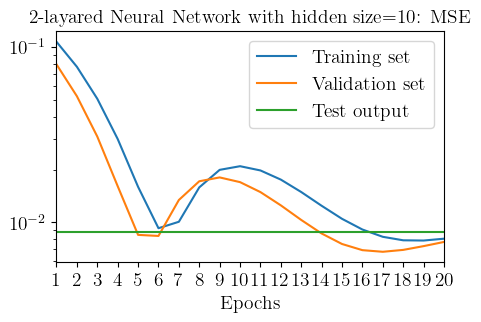

In [71]:
#@title #####**Click to Start Training**

"Notice:"
# For Decision Tree, Bagged Trees, Random Forest and kNN, the training loop runs as follows:
# We train over the training set and validate over the validation set EACH time in the loop (this is the current implementation).
# These loops fit a different model at EACH time in the loop -- hence, the loop is just for visulization as there is no continuation between consecuitive models in the training loop.
# The training loop for each model ierates over values of a corresponding hyper-parameters.
# Technically, we should choose the best model over the validation set (we need to save the best model) and evaluate the perfomance of this best model over the test set.


# The different depths in the loop are just for visualization, as every time a different model is trained (see remark above)
if decision_tree:
    decisionTree, results_DT = decisionTreeRegTrain(dataset=dataset, max_depth=max_depth_DT)
    decisionTreePlot(decisionTree, results_DT)


# The different depths in the loop are just for visualization, as every time a different model is trained (see remark above)
if bagged_trees:
    baggedTrees, results_BT = baggedTreesRegTrain(dataset=dataset, max_depth=max_depth_BT, n_estimators=n_estimators_BT)
    baggedTreesPlot(baggedTrees, results_BT)


# The different depths in the loop are just for visualization, as every time a different model is trained (see remark above)
if random_forest:
    randomForest, results_RF = randomForestRegTrain(dataset=dataset, max_depth=max_depth_RF, n_estimators=n_estimators_RF)
    randomForestPlot(randomForest, results_RF)


if gradient_boosting:
    gradBoost, results_GB = gradBoostRegTrain(dataset=dataset, num_epochs=num_epochs_GB, n_estimators=n_estimators_GB, lr=lr_GB, max_depth=max_depth_GB)
    gradBoostPlot(gradBoost, results_GB)


if linear_regression:
    linearReg, results_LR = linearRegTrain(dataset=dataset)


# The different values for nearest neighbors in the loop are just for visualization, as every time a different model is trained (see remark above)
if kNN:
    kNN, results_kNN = kNNRegTrain(dataset=dataset, n_neighbors=n_neighbors)
    kNNPlot(kNN, results_kNN)


if neural_network:
    results_NN = neuralNetReg(dataset=dataset, hidden_dim=hidden_dim_NN, lr=lr_NN, num_epochs=num_epochs_NN)
    neuralNetPlot(results_NN)